<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/hungarian/data_processing/lessons/hid_hang_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hang és videó feldolgozás

##Busz áthaladások megkeresése a hangból

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.io.wavfile import read     # for read sound file

Töltsük fel a hang fájlt.

In [60]:
!wget http://www.agt.bme.hu/siki/automatizalas/2023/erzsebet.wav

--2024-05-01 14:43:18--  http://www.agt.bme.hu/siki/automatizalas/2023/erzsebet.wav
Resolving www.agt.bme.hu (www.agt.bme.hu)... 152.66.5.8
Connecting to www.agt.bme.hu (www.agt.bme.hu)|152.66.5.8|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102781006 (98M) [audio/x-wav]
Saving to: ‘erzsebet.wav.1’

erzsebet.wav.1      100%[===================>]  98.02M  9.20MB/s    in 12s     

2024-05-01 14:43:31 (8.05 MB/s) - ‘erzsebet.wav.1’ saved [102781006/102781006]



A hang fájl beolvasása során megkapjuk a mintavételezési frekvenciát (fs). Rajzoljuk ki a hullám alakot az első 20 másodpercben.

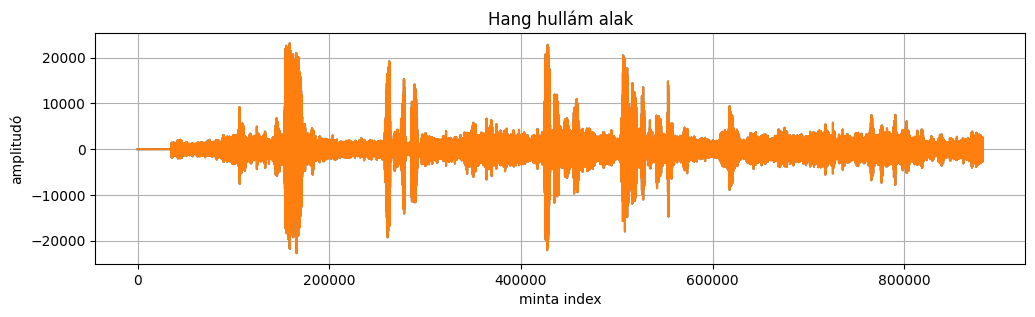

In [66]:
fs, snd_data = read('erzsebet.wav')         # fs sample frequency
fig=plt.figure(figsize=(12,3))
plt.plot(snd_data[:20 * fs])
plt.xlabel('minta index')
plt.ylabel('amplitudó')
plt.title('Hang hullám alak')
plt.grid()

Első másodpercet vágjuk le az elején (csend).

In [67]:
snd_data = snd_data[44100:]

Állítsuk be a kezdő időpontot (14:49:50+1). Az idő szinkronizálás nagyon fontos a különböző módszerekkel kapott eredmények összevetésére.

In [68]:
tstart = float(14 * 3600 + 49 * 60 + 50 + 1)                 # start time from midnight in seconds

A sztereo hangot alakítsuk monová és skálázzuk át az adatokat -1, 1 közé.

In [70]:
if len(snd_data.shape) > 1:
    snd_data = np.mean(snd_data, axis=1)       # stereo to mono
snd_data = snd_data / np.max(np.abs(snd_data)) # normalize to -1 - +1 range
print(f'{snd_data.shape[0] / fs:.1f} seconds, {fs} Hz sound ')

25233.0
581.7 seconds, 44100 Hz sound 


**RMS hangnyomás számítás**

Minél nagyobb a hanghullám oszcillációja, annál intenzívebb hangott hallunk. A hanghullám intenzitása arányos egy időintervallumban átlagolt négyzetekkel, a hangnyomással ($P_{RMS}$).

$P_{RMS} = \sqrt{\frac{\sum_{dt} s_i^2} {n}}; dt = 0.1 sec;$

In [83]:
wint = 0.1                                      # time window 0.1 s
wins = int(wint * fs)                           # time window width in index
n = snd_data.shape[0] // wins                   # number of time windows
p = snd_data[:wins * n].reshape((-1, wins))     # change to 2D array
prms = np.sqrt(np.sum(np.square(p), axis=1) / wins)
tend = tstart + (prms.shape[0]) * wint       # end time in seconds from midnight
t = np.arange(tstart, tend, wint)               #

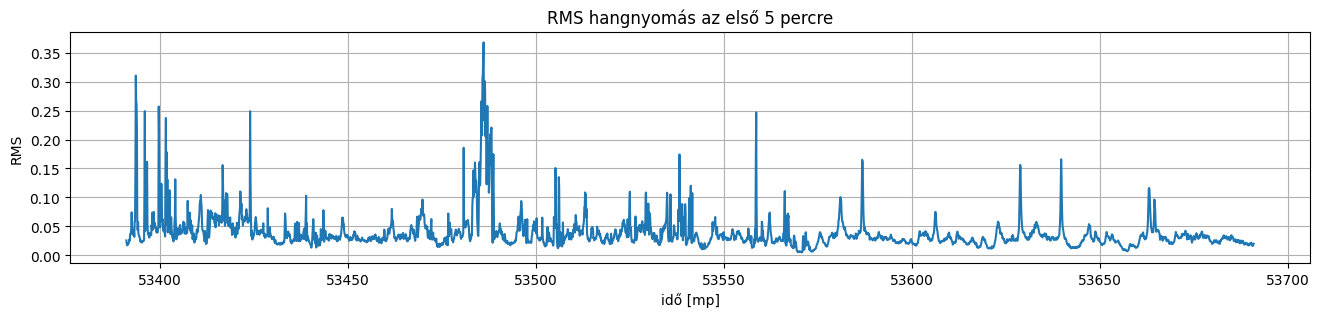

In [73]:
plt.figure(2, figsize=(16,3))
plt.plot(t[:int(300 // wint)], prms[:int(300 // wint)])
plt.xlabel('idő [mp]')
plt.ylabel('RMS')
plt.title('RMS hangnyomás az első 5 percre')
plt.grid()

A hangnyomást gyakran egy relatív értékkel adják meg, decibel egységben. A hangnyomást egy referencia nyomáshoz viszonyítjuk.

$SPL = 20 log_{10} \frac{P_{RMS}} {P_{ref}}$

In [76]:
pref = np.min(prms)
spl = 20 * np.log10(prms / pref)

Simítsuk az adatainkat 1.1 másodperces mozgó ablakban a mediánnal. Ezzel csökkentjük egy-egy kiugró érték hatását

$mSPL = median(SPL)_{dt}; dt = 1.1 sec$


In [77]:
win2t = 1.1                     # moving window of 1.1 seconds
win2s = int(win2t // wint)
m = (win2s - 1) // 2
mspl = np.zeros(n)
for i in range(m, n - m - 1):
    mspl[i] = np.median(spl[i - m: i + m])

Rajzoljunk ki egy 60 másodperces részt az adatokból.

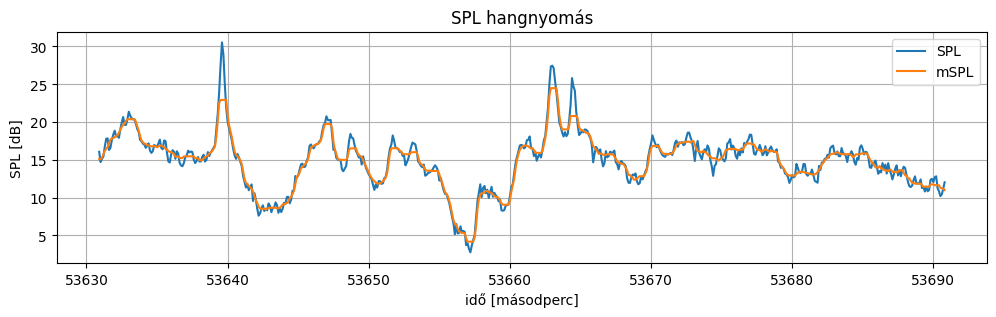

In [86]:
l1 = int(240 // wint)
l2 = int(300 // wint)              # length of plot in seconds
plt.figure(3, figsize=(12,3))
plt.plot(t[l1:l2], spl[l1:l2], label="SPL")
plt.plot(t[l1:l2], mspl[l1:l2], label="mSPL")
plt.xlabel('idő [másodperc]')
plt.ylabel('SPL [dB]')
plt.title('SPL hangnyomás')
plt.grid()
_ = plt.legend()

Állítsunk fel egy korlátot, ami feletti hangnyomás esetén egy busz mehetett el.

77 másodperc a kritikus érték felett (13.2%)


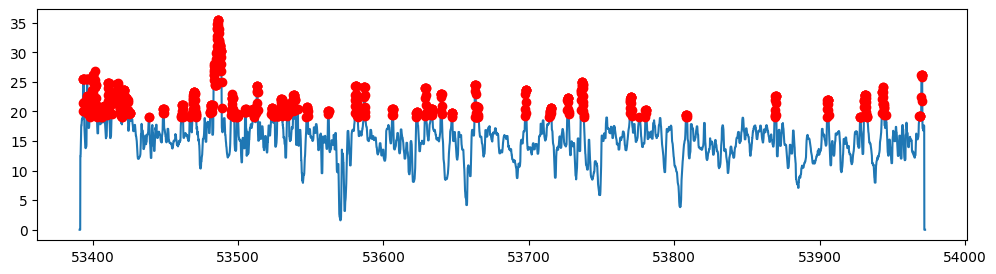

In [85]:
critical = 19.0         # minimal sound presure of a bus
snd = np.c_[t, mspl]
snd_bus = snd[snd[:,1] > critical]
print(f'{snd_bus.shape[0] * wint:.0f} másodperc a kritikus érték felett ({snd_bus.shape[0]/snd.shape[0]:.1%})')
plt.figure(4, figsize=(12,3))
plt.plot(t, mspl)
_ = plt.plot(snd_bus[:,0], snd_bus[:,1], 'ro')

Gyűjtsük ki azokat az intervallumokat, amikor a hangnyomás a kritikus érték felett volt. Ezeket írjuk ki egy fájlba (snd_bus.txt).

In [89]:
start = 0                               # start row index of the first bus
sbus = []
for i in range(1, snd_bus.shape[0]):    # for each row except first
  if snd_bus[i,0] - snd_bus[i-1,0] > wint: # gap -> new bus arrived
    if snd_bus[i-1,0] - snd_bus[start,0] > 0.5:  # pass longer than 0.5 seconds?
      sbus.append((np.average(snd_bus[start:i,0]),
                  np.max(snd_bus[start:i,1]),
                  int(snd_bus[i-1,0] - snd_bus[start, 0] + 0.5)))           # store time, max deflection and duration (sec)
    start = i
# add last
if snd_bus[-1,0] - snd_bus[start,0] > 0.5:
  sbus.append((np.average(snd_bus[start:,0]),
              np.max(snd_bus[start:,1]),
              int(snd_bus[-1,0] - snd_bus[start,0] + 0.5)))
print(f'{len(sbus)} buszt feltételezünk')
print(f'idő      max.zaj tartam')
fo = open('sample_data/snd_bus.txt', 'w')
for b in sbus:
  print(f'{datetime.fromtimestamp(b[0]).strftime("%H:%M:%S"):8s} {b[1]:5.1f} {b[2]:5d}')
  print(f'{b[0]:.1f} {b[1]:.1f} {b[2]}', file=fo)
fo.close()

44 buszt feltételezünk
idő      max.zaj tartam
14:49:53  25.6     1
14:49:56  25.5     1
14:50:00  26.9     5
14:50:06  19.4     1
14:50:07  20.9     1
14:50:10  24.8     1
14:50:16  24.9     6
14:50:22  23.7     4
14:50:48  20.5     1
14:51:01  21.1     1
14:51:09  23.3     2
14:51:21  21.1     1
14:51:25  35.5     6
14:51:36  23.0     2
14:51:39  19.5     1
14:51:45  20.4     1
14:51:50  20.5     1
14:51:53  24.4     1
14:52:03  20.5     1
14:52:08  22.1     3
14:52:14  21.3     1
14:52:18  22.8     1
14:52:27  20.7     1
14:53:01  24.3     2
14:53:06  24.1     1
14:53:26  20.5     1
14:53:42  19.8     1
14:53:48  24.0     1
14:53:53  20.4     1
14:53:59  22.9     1
14:54:07  19.7     1
14:54:23  24.5     2
14:54:57  23.6     1
14:55:14  20.7     1
14:55:26  22.4     1
14:55:36  24.9     2
14:56:10  22.5     1
14:56:20  20.2     1
14:56:48  19.4     1
14:57:49  22.7     1
14:58:25  22.0     1
14:58:51  22.8     2
14:59:03  24.2     2
14:59:30  26.2     1


##Busz áthaladások megkeresése videó felvételből

A híd közepén készített videó felvételt használjuk.


In [90]:
import cv2
!gdown --id 1wIFIpzRRm_lngAv74D1xMV1wc56_kocI -O sample_data/bridge_vid.mp4
!gdown --id 1P5Bq797ROdvCkIxdXCgHazfI01El2H8_ -O sample_data/empty_bridge.png
!gdown --id 1hiNd2P8q9hfwUYXeC8cYqLZM43PaytAZ -O sample_data/blue_bus.png

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1wIFIpzRRm_lngAv74D1xMV1wc56_kocI
From (redirected): https://drive.google.com/uc?id=1wIFIpzRRm_lngAv74D1xMV1wc56_kocI&confirm=t&uuid=0a7cb60e-a2ae-428c-a48d-ba86dd83c557
To: /content/sample_data/bridge_vid.mp4
100% 294M/294M [00:05<00:00, 57.9MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1P5Bq797ROdvCkIxdXCgHazfI01El2H8_
To: /content/sample_data/empty_bridge.png
100% 559k/559k [00:00<00:00, 97.0MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: O

Két minta képet készítettünk elő. Egyiken az üres hidat, a másikon pedig egy busz áthaladást láthatunk.

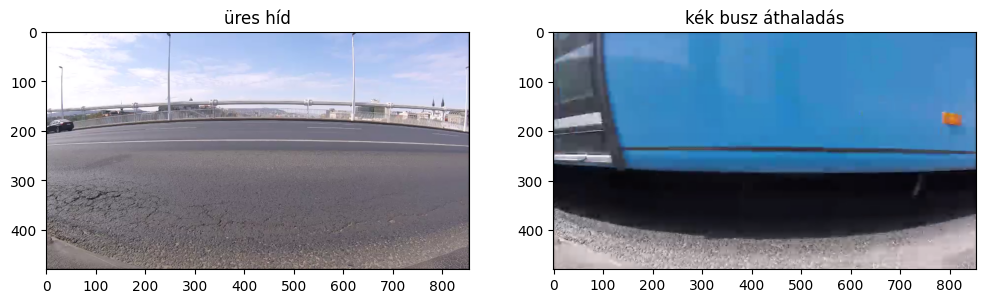

In [91]:
img1 = cv2.imread('sample_data/empty_bridge.png')
img2 = cv2.imread('sample_data/blue_bus.png')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))            # use two subplots horizontaly
ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax1.title.set_text('üres híd')
ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax2.title.set_text('kék busz áthaladás')


Milyen egyszerű feltétel alapján tudjuk a két képet megkülönböztetni?

Elég lenne a kép egy kis részét használni az elemzéshez. Mivel csak a közelebbi busz sávot vizsgáljuk vágjuk le a járdát tartalmazó részt.

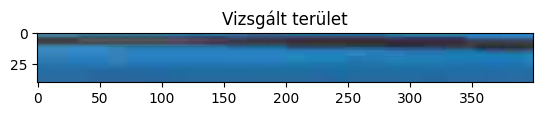

In [93]:
plt.imshow(cv2.cvtColor(img2[230:270,200:600], cv2.COLOR_BGR2RGB))
_ = plt.title("Vizsgált terület")

Egy nagyon egyszerű indikátor értékként használjuk a pixelek átlag értékét.

In [95]:
low = 230       # window to check
high = 270
left = 200
right = 600
indicator_empty = np.mean(img1[low:high, left:right])
indicator_bus = np.mean(img2[low:high, left:right])
print(f'Üres: {indicator_empty:.1f}, Busz: {indicator_bus:.1f}')

Üres: 123.2, Busz: 100.8


In [108]:
lower = np.array([95, 100, 20])
higher = np.array([140, 255, 255])
indicator_bus = np.sum(cv2.inRange(cv2.cvtColor(img2[low:high, left:right], cv2.COLOR_BGR2HSV), lower, higher)) // 255
indicator_empty  = np.sum(cv2.inRange(cv2.cvtColor(img1[low:high, left:right], cv2.COLOR_BGR2HSV), lower, higher)) // 255
print(f'Üres: {indicator_empty:.1f}, Busz: {indicator_bus:.1f}')

Üres: 0.0, Busz: 13991.0


Állítsuk be az fps és a kezdő időpont értékét.

In [122]:
source = cv2.VideoCapture('sample_data/bridge_vid.mp4')
fps = source.get(cv2.CAP_PROP_FPS)        # frame / seconds from video
print(f'videó fps: {fps}')
act = tstart = 14 * 3600 + 49 * 60 + 50   # seconds from midnight
dt = 1 / fps                              # time step between frames (sec)

videó fps: 29.97


Képkockánként végigmegyünk a felvételen és kiszámítjuk az indikátor értéket (ez néhány percet is igénybe vehet).

In [123]:
video_data = []
while True:
  ret, frame = source.read()                    # read next frame
  if ret:
    #val = np.mean(frame[low:high, left:right])  # calculate indicator
    val = np.sum(cv2.inRange(cv2.cvtColor(frame[low:high, left:right], cv2.COLOR_BGR2HSV), lower, higher)) // 255
    video_data.append((act, val))
    act += dt
  else:
    break
source.release()

In [125]:
len(video_data)

59877

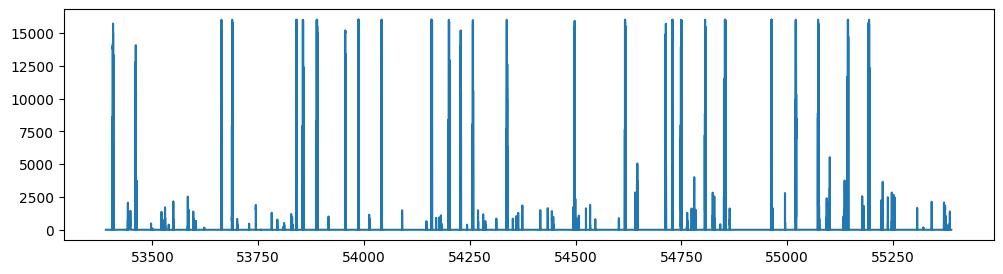

In [126]:
vid_bus = np.array(video_data)
plt.figure(figsize=(12,3))
plt.plot(vid_bus[:,0], vid_bus[:,1])

In [129]:
critical = 10000
v_bus = vid_bus[vid_bus[:,1] > critical]
print(f'{v_bus.shape[0] / fps:.0f} másodperc a kritikus érték felett ({v_bus.shape[0]/vid_bus.shape[0]:.1%})')

12 másodperc a kritikus érték felett (0.6%)


In [132]:
start = 0                               # start row index of the first bus
vbus = []
for i in range(1, v_bus.shape[0]):    # for each row except first
  if v_bus[i,0] - v_bus[i-1,0] > 1:   # gap -> new bus arrived
    if v_bus[i-1,0] - v_bus[start,0] > 1: # pass longer than 1 seconds?
      vbus.append((np.average(v_bus[start:i,0]),
                  np.min(v_bus[start:i,1]),
                  int(v_bus[i-1,0] - v_bus[start,0] + 0.5)))           # store time, max deflection and duration (sec)
    start = i
# add last
if v_bus.shape[0] - start > 1:
  vbus.append((np.average(v_bus[start:,0]),
              np.max(v_bus[start:,1]),
              v_bus.shape[0]-start))
print(f'{len(vbus)} buszt feltételezünk')
print(f'time    indikátor időtartam')
print(f'hh:mm:ss  db        sec')
fo = open('sample_data/vid_bus.txt', 'w')
for b in vbus:
  print(f'{datetime.fromtimestamp(b[0]).strftime("%H:%M:%S"):8s} {b[1]:5.1f} {b[2]:5d}')
  print(f'{b[0]:.1f} {b[1]:.1f} {b[2]}', file=fo)
fo.close()

22 buszt feltételezünk
time    indikátor időtartam
hh:mm:ss  db        sec
14:50:06 10314.0     1
14:51:00 10653.0     1
14:54:23 10132.0     1
14:54:48 10250.0     2
14:57:35 10513.0     1
14:58:08 11367.0     1
14:59:47 10009.0     1
15:00:41 10046.0     1
15:02:40 10947.0     1
15:03:20 11452.0     1
15:03:48 10113.0     2
15:05:37 10047.0     1
15:08:17 11203.0     1
15:10:17 10347.0     1
15:12:29 10213.0     1
15:13:26 10235.0     1
15:14:12 10190.0     1
15:16:02 10348.0     2
15:17:00 10312.0     1
15:17:53 10304.0     1
15:19:03 10020.0     1
15:19:53 15997.0    11


**Feladatok**

* Nézze meg a videó felvételt és jegyezze fel a busz áthaladásokat, hasonlítsa össze a valódi áthaladásokat a különböző módszerekkel meghatározottal!
* Próbáljon olyan indikátor értéket kitalálni, mely nem kék színű buszokat is érzékeli.
* Vesse össze az egyes módszerekkel kimutatott busz áthaladásokat. Készítsen, az összes módszer eredményének figyelembe vételével, egy döntési mehanizmust.

